In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud # pip install wordcloud

%matplotlib inline  

%run 'DataSet.py'
%run 'Processing.py'

Play  ['Hamlet' 'Othello' 'Henry V' 'Timon of Athens' 'Measure for Measure'
 'Antony and Cleopatra' 'King Lear' 'King Edward III' 'Julius Caesar'
 'Macbeth' 'Titus Andronicus' "The Winter's Tale" 'Richard III'
 'As You Like It' 'Coriolanus' 'The Tempest' 'Henry IV Part 2'
 'Romeo and Juliet' 'Pericles' 'Henry IV Part 1' 'Cymbeline'
 'The Two Noble Kinsmen' "Love's Labour's Lost" 'The Taming of the Shrew'
 'The Merchant of Venice' 'Troilus and Cressida' 'King John'
 "All's Well That Ends Well" 'Richard II' 'Henry VIII'
 'The Two Gentlemen of Verona' 'The Merry Wives of Windsor'
 'Henry VI Part 3' 'Much Ado About Nothing' 'Henry VI Part 1'
 'Henry VI Part 2' 'Twelfth Night' 'The Comedy of Errors'
 "A Midsummer Night's Dream"]
[('thou', 5333), ('thy', 3795), ('shall', 3572), ('thee', 3090), ('good', 2825), ('lord', 2679), ('come', 2531), ('sir', 2520), ('well', 2488), ('would', 2294)]


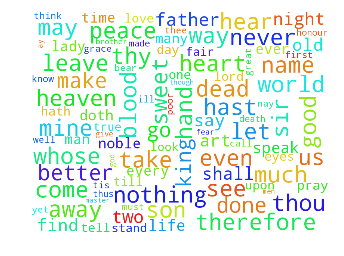

In [2]:
ds = DataSet()
ds.load()

tokens = Processing.get_tokens(ds.df['Utterance'], [Processing.remove_punctuation], [Processing.remove_stopwords])

allWordDist = nltk.FreqDist(tokens)

common_words = allWordDist.most_common(100)

# Print the top 10 words - shows some 'olde english' stop words
print(allWordDist.most_common(10))

words = ' '.join(entry[0] for entry in common_words)


# lower max_font_size
wordcloud = WordCloud(background_color='white', max_font_size=60,height=600, width=800).generate(words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag


stemmer = SnowballStemmer("english")


def run_tfidf(words, stem=False):
    all_stopwords = stopwords.words('english') 

    #adding Shakespeare-ean stop-words
    shaksp_stopwords = ('thee', 'thou', 'thy', 'thine')
    all_stopwords += shaksp_stopwords

    tfidf_vectorizer = TfidfVectorizer(#max_features=200000,
                                        max_features=1000,
                                       min_df=0.2, 
                                       max_df=0.8, 
                                       stop_words=all_stopwords,
                                        use_idf=True, 
                                        tokenizer=tokenize_and_stem if stem else tokenize_only, 
                                        ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(words)
    
    return tfidf_matrix, tfidf_vectorizer.get_feature_names()


def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

    
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens    
    


In [4]:
plays_utterances = ds.get_by_play()

tfidf_matrix, terms = run_tfidf(plays_utterances.values())

In [5]:
from sklearn.cluster import KMeans
from collections import Counter
    
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()



In [6]:

plays_dict = { 'title': list(plays_utterances.keys()),'cluster': clusters}

frame = pd.DataFrame(plays_dict, index = [clusters] , columns = [
        'title', 'cluster'])


In [7]:
frame['cluster'].value_counts()

3    15
2    10
4     7
1     3
0     2
Name: cluster, dtype: int64

In [8]:

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in plays_utterances.values():
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)


In [9]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    
    print("Cluster {} words:".format(i))
    for ind in order_centroids[i, :6]:
        print(' {}'.format(terms[ind]))
    print()
    
    print("Cluster {} titles:".format(i))
    for title in frame.ix[i]['title'].values.tolist():
        print(' {},'.format(title))
    print()
    print()

Top terms per cluster:

Cluster 0 words:
 caesar
 brutus
 caesar 's
 rome
 gods
 roman

Cluster 0 titles:
 j_caesar,
 a_and_c,


Cluster 1 words:
 john
 sir john
 harry
 page
 jack
 sack

Cluster 1 titles:
 hen_iv_1,
 hen_iv_2,
 m_wives,


Cluster 2 words:
 signior
 duke
 friar
 letter
 count
 cousin

Cluster 2 titles:
 much_ado,
 m_for_m,
 as_you,
 r_and_j,
 taming,
 two_gent,
 com_err,
 lll,
 all_well,
 t_night,


Cluster 3 words:
 gods
 rome
 'em
 prithee
 court
 general

Cluster 3 titles:
 merchant,
 othello,
 macbeth,
 cymbelin,
 tempest,
 timon,
 hen_viii,
 lear,
 hamlet,
 coriolan,
 dream,
 troilus,
 titus,
 win_tale,
 pericles,


Cluster 4 words:
 france
 henry
 york
 england
 duke
 richard

Cluster 4 titles:
 rich_iii,
 hen_v,
 john,
 hen_vi_2,
 rich_ii,
 hen_vi_1,
 hen_vi_3,




In [10]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [11]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: '0', 
                 1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4'}

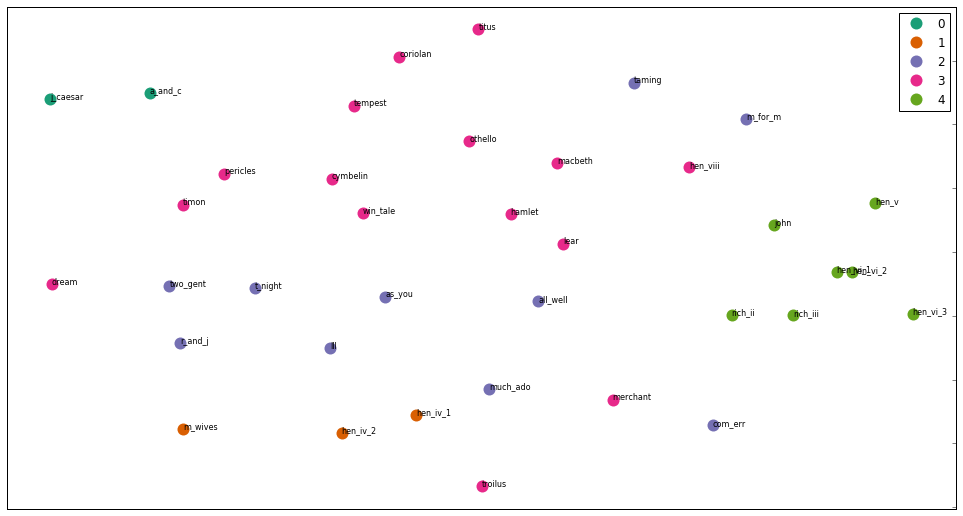

In [12]:
%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=frame['cluster'], title=frame['title'])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that we use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i, row in df.iterrows():
    ax.text(row['x'], row['y'], row['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)